In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [17]:
# Configure matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 14
})

In [18]:
# Load the log file
log_file = 'log_files/logxxxx.log'
data = pd.read_csv(log_file)

# Display the first few rows and columns
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())
print(f"\nTotal data points: {len(data)}")

Columns: ['time', 'x', 'y', 'z', 'yaw', 'ctrl_comp_time', 'rollout_comptime', 'y_ref', 'z_ref', 'yaw_ref', 'throttle', 'roll_rate', 'pitch_rate', 'yaw_rate', 'save_tube_pyH', 'save_tube_pyL', 'save_tube_pzH', 'save_tube_pzL', 'wy', 'wz']

First few rows:
        time         x         y          z       yaw  ctrl_comp_time  \
0  15.066843  0.033007  3.751996 -12.305882 -0.002348        0.201169   
1  15.735131  0.043001  3.750754 -12.260855  0.000452        0.210777   
2  16.049937  0.043001  3.750754 -12.260855  0.000452        0.002476   
3  16.189736  0.094301  3.307898 -11.336839  0.006129        0.004491   
4  16.198224  0.094301  3.307898 -11.336839  0.006129        0.002761   

   rollout_comptime     y_ref      z_ref   yaw_ref  throttle  roll_rate  \
0          0.152454  3.742892 -12.313489 -0.003926  0.579735  -1.000000   
1          0.130023  3.746303 -12.316440 -0.043926  0.612412  -0.225744   
2          0.144723  3.749412 -12.313538 -0.083926  0.605294  -1.000000   
3     

In [19]:
# Extract relevant data and FLIP Z
# Data structure: every 7 rows = 1 timestep (first row has actual state, all 7 rows have ref/tube)
num_refs_per_step = 7

time_raw = data['time'].values
y_raw = data['y'].values
z_raw = -data['z'].values  # FLIP Z
y_ref_raw = data['y_ref'].values
z_ref_raw = -data['z_ref'].values  # FLIP Z

# Reachable tube bounds - FLIP Z
pyH_raw = data['save_tube_pyH'].values
pyL_raw = data['save_tube_pyL'].values
pzH_raw = -data['save_tube_pzL'].values  # FLIPPED - note swap
pzL_raw = -data['save_tube_pzH'].values  # FLIPPED - note swap

# Reshape data: group every 7 rows
num_timesteps = len(data) // num_refs_per_step
print(f"Total rows: {len(data)}")
print(f"References per timestep: {num_refs_per_step}")
print(f"Number of actual timesteps: {num_timesteps}")

# Extract actual state (first row of each group of 7)
time = time_raw[::num_refs_per_step]
y = y_raw[::num_refs_per_step]
z = z_raw[::num_refs_per_step]

# Reshape reference and tube data into (num_timesteps, 7) arrays
y_ref_all = y_ref_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)
z_ref_all = z_ref_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)
pyH_all = pyH_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)
pyL_all = pyL_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)
pzH_all = pzH_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)
pzL_all = pzL_raw[:num_timesteps * num_refs_per_step].reshape(num_timesteps, num_refs_per_step)

print(f"\nTime range: {time[0]:.2f} to {time[-1]:.2f} seconds")
print(f"Y range: {np.nanmin(y):.2f} to {np.nanmax(y):.2f}")
print(f"Z range: {np.nanmin(z):.2f} to {np.nanmax(z):.2f}")
print(f"\nTube Y width range: {np.nanmin(pyH_all - pyL_all):.3f} to {np.nanmax(pyH_all - pyL_all):.3f}")
print(f"Tube Z height range: {np.nanmin(pzH_all - pzL_all):.3f} to {np.nanmax(pzH_all - pzL_all):.3f}")
print(f"\nReference array shape: {y_ref_all.shape}")
print(f"Tube array shape: {pyH_all.shape}")

Total rows: 2450
References per timestep: 7
Number of actual timesteps: 350

Time range: 15.07 to nan seconds
Y range: -0.78 to 3.75
Z range: 1.39 to 12.31

Tube Y width range: 0.001 to 0.693
Tube Z height range: 0.001 to 0.582

Reference array shape: (350, 7)
Tube array shape: (350, 7)


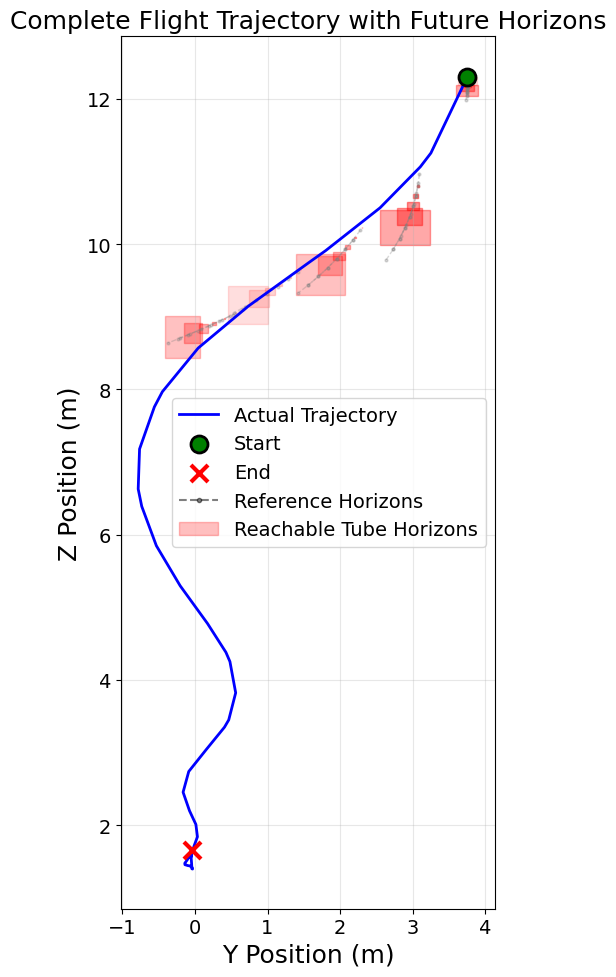

Static plot created and saved as 'log_static_plot.png'!


In [20]:
# Create a static plot showing the full trajectory
fig, ax = plt.subplots(figsize=(14, 10))

FONTSIZE = 18
LINEWIDTH = 2

# Plot full actual trajectory
ax.plot(y, z, label='Actual Trajectory', color='blue', linewidth=LINEWIDTH, zorder=3)

# Find first and last non-NaN values
start_idx = 0
for i in range(len(y)):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        start_idx = i
        break

end_idx = len(y) - 1
for i in range(len(y) - 1, -1, -1):
    if not (np.isnan(y[i]) or np.isnan(z[i])):
        end_idx = i
        break

# Plot start and end positions
ax.scatter(y[start_idx], z[start_idx], color='green', s=150, 
           marker='o', label='Start', zorder=5, edgecolors='black', linewidths=2)
ax.scatter(y[end_idx], z[end_idx], color='red', s=150, 
           marker='x', label='End', zorder=5, linewidths=3)

# Sample several timesteps to show reference horizons
num_sample_times = 12
sample_indices = np.linspace(start_idx, end_idx, num_sample_times, dtype=int)

ref_horizon_plotted = False
tubes_plotted = False

for idx in sample_indices:
    # Plot the reference horizon (7 future points) at this timestep
    ref_y_horizon = y_ref_all[idx, :]
    ref_z_horizon = z_ref_all[idx, :]
    
    if not ref_horizon_plotted:
        ax.plot(ref_y_horizon, ref_z_horizon, linestyle='dashed', 
               color='black', linewidth=1.5, alpha=0.5, marker='o', 
               markersize=3, label='Reference Horizons', zorder=2)
        ref_horizon_plotted = True
    else:
        ax.plot(ref_y_horizon, ref_z_horizon, linestyle='dashed', 
               color='gray', linewidth=1, alpha=0.3, marker='o', 
               markersize=2, zorder=2)
    
    # Plot all 7 tubes along this horizon
    for i in range(num_refs_per_step):
        if not (np.isnan(pyL_all[idx, i]) or np.isnan(pzL_all[idx, i]) or 
                np.isnan(pyH_all[idx, i]) or np.isnan(pzH_all[idx, i])):
            tube_width = pyH_all[idx, i] - pyL_all[idx, i]
            tube_height = pzH_all[idx, i] - pzL_all[idx, i]
            
            if tube_width > 0 and tube_height > 0 and tube_width < 100 and tube_height < 100:
                # Fade alpha along the horizon (closest is darker, future is lighter)
                alpha_val = 0.25 - (i * 0.02)
                rect = Rectangle((pyL_all[idx, i], pzL_all[idx, i]), 
                                tube_width, tube_height,
                                linewidth=1, edgecolor='red', facecolor='red', 
                                alpha=alpha_val, linestyle='-', zorder=1)
                ax.add_patch(rect)
                if not tubes_plotted:
                    rect.set_label('Reachable Tube Horizons')
                    tubes_plotted = True

ax.set_xlabel('Y Position (m)', fontsize=FONTSIZE)
ax.set_ylabel('Z Position (m)', fontsize=FONTSIZE)
ax.set_title('Complete Flight Trajectory with Future Horizons', fontsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE - 4, loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('log_static_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Static plot created and saved as 'log_static_plot.png'!")